Lab 3 Data analysis QMSSGR5015

Bowen Bao

In [ ]:
import pandas as pd
import requests
import zipfile
import io
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

I would like to use GSS data, let's go for 2022 only

In [ ]:
url = 'https://gss.norc.org/content/dam/gss/get-the-data/documents/stata/2022_stata.zip'

response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))
block_size = 1024

tqdm_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
content = io.BytesIO()

for data in response.iter_content(block_size):
    tqdm_bar.update(len(data))
    content.write(data)

tqdm_bar.close()

if total_size != 0 and tqdm_bar.n != total_size:
    print("Error in downloading the file")
else:
    print("Download completed")

  0%|          | 0.00/5.28M [00:00<?, ?iB/s]

Download completed


1. choose two variables:
the first variable I want to use is the ordinal varibale affrmact, which represents the level of favor or oppose Black preference in hiring and promotion due to past discrimination. The question asks: Some people say that because of past discrimination,
Blacks should be given preference in hiring and promotion.
Others say that such preference in hiring and promotion of
Blacks is wrong because it discriminates against Whites.
What about your opinion?
value 1, 2, 3, 4 represents strong favor, not strong favor, not strong oppose and strong oppose.

The second variable I want to use is age, which is basically the age of the respondent, values 18-89 represent the age of the respondent from 18 year old to 89 or more. Get the two variables:

In [ ]:
with zipfile.ZipFile(content) as z:
    file_list = z.namelist()
    stata_files = [file for file in file_list if file.endswith('.dta')]

    if stata_files:
        stata_file = stata_files[0]

        with z.open(stata_file) as stata_file_stream:
          columns_to_load = ['id', 'age', 'affrmact']
          print("Loading selected columns from Stata file with numeric labels")
          df_numeric = pd.read_stata(stata_file_stream, columns=columns_to_load, convert_categoricals=False)
          print("Data with numeric labels loaded successfully")

        with z.open(stata_file) as stata_file_stream:
          print("Loading selected columns from Stata file with string (categorical) labels")
          df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)
          print("Data with categorical labels loaded successfully")

df_categorical = df_categorical.rename(columns={col: f'z{col}' for col in df_categorical.columns})
df = pd.concat([df_numeric, df_categorical], axis=1)
df.head()

Loading selected columns from Stata file with numeric labels
Data with numeric labels loaded successfully
Loading selected columns from Stata file with string (categorical) labels
Data with categorical labels loaded successfully


,id,age,affrmact,zid,zage,zaffrmact
0,1,72.0,NaN,1,72.0,NaN
1,2,80.0,4.0,2,80.0,strongly opposes
2,3,57.0,NaN,3,57.0,NaN
3,4,23.0,3.0,4,23.0,not strongly opposes
4,5,62.0,NaN,5,62.0,NaN


I want to dot the age first. Let's break the age into four groups: young adults: 18-34, adults: 35-45, middle aged: 46-65, and senior citizens: 66-89

In [ ]:
conditions = [
    (df['age'] <= 34) & (df['age'] >17) ,
    (df['age'] >34 ) & (df['age'] <=45),
    (df['age'] >45 ) & (df['age'] <=65),
    (df['age'] > 65)]
choices = ["Young Adults", "Adults", "Middle Aged", "Senior Citizens"]
df['age'] = np.select(conditions, choices, default=np.nan)

In [ ]:
df['age'] = df['age'].replace('nan', np.nan)

In [ ]:
df.age.value_counts(dropna=False)

,count
age,
Middle Aged,1209
Young Adults,1094
Senior Citizens,811
Adults,779
NaN,256


Then lets' do affrmact, I want to make it simple, so let's go with favor vs oppose. Support=1 strong favor, 2 moderate favor, oppose=3 moderate oppose, 4 strong oppose.

In [ ]:
conditions = [
    (df['affrmact'] >= 1) & (df['affrmact'] <=2) ,
    (df['affrmact'] >=3 ) & (df['affrmact'] <=4),
]
choices = ["Favor", "Oppose"]
df['affrmact'] = np.select(conditions, choices, default=np.nan)

In [ ]:
df['affrmact'] = df['affrmact'].replace('nan', np.nan)

In [ ]:
df.affrmact.value_counts(dropna=False)

,count
affrmact,
Oppose,1839
NaN,1543
Favor,767


2. Now let's do a cross-tabulation, I expect age will have a significant affect on the level of favor, as we usually think that young people are more liberal and have different thoughts on how to solve social inequalities:

In [ ]:
pd.crosstab(df.age, df.affrmact, normalize='columns')*100

affrmact,Favor,Oppose
age,,
Adults,22.145805,19.674985
Middle Aged,26.822558,33.546140
Senior Citizens,16.231087,21.009867
Young Adults,34.800550,25.769008


It seems that young adults and adults favors the opinion to compensate Black population in our society more than middle aged and senior citizens. Let's do a graph.

<Axes: xlabel='age'>

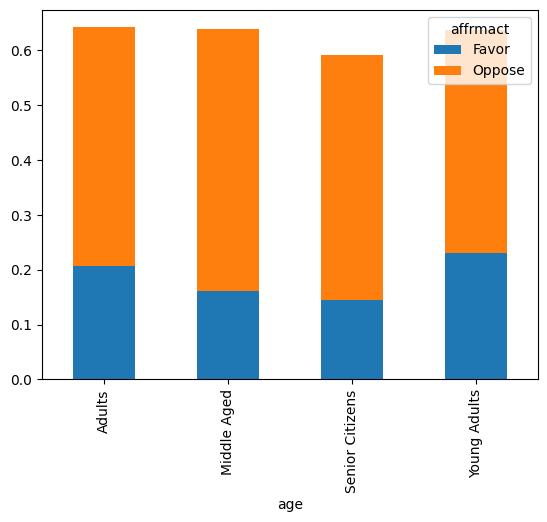

In [ ]:
variables = ['age', 'affrmact']

group_counts = df.groupby(variables).size()

total_counts = df.groupby(variables[0]).size()

percentages = group_counts / total_counts

percentages.unstack().plot(kind='bar', stacked=True)

There is indeed a difference! We can also see that young adults, adults and middle aged people are more likely to respond to the question and express their opinion, while more senior citizens choose to skip or not answer it.



The cross-tabulation shows that while overall people are opposing the idea which suggests Black preference in hiring and promoting as a compensation to past discriminations, younger population always favor the opinion more than the older population, which can be observed through the blue chart. Young people are also more likely to respond to the question, which also be observed through the length of the orange and blue bars combined.

3. Correlations should be run with intervo-ratio variables so we will run a correlation with new variables: educ, highest school years completed (0-20) and maeduc, highest school years the respondent's mother completed (0-20). I assume that mothers who are well-educated will have well-educated children.

In [ ]:
with zipfile.ZipFile(content) as z:
    file_list = z.namelist()
    stata_files = [file for file in file_list if file.endswith('.dta')]

    if stata_files:
        stata_file = stata_files[0]

        with z.open(stata_file) as stata_file_stream:
          columns_to_load = ['id', 'maeduc', 'educ']
          print("Loading selected columns from Stata file with numeric labels")
          df_numeric = pd.read_stata(stata_file_stream, columns=columns_to_load, convert_categoricals=False)
          print("Data with numeric labels loaded successfully")

        with z.open(stata_file) as stata_file_stream:
          print("Loading selected columns from Stata file with string (categorical) labels")
          df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)
          print("Data with categorical labels loaded successfully")

df_categorical = df_categorical.rename(columns={col: f'z{col}' for col in df_categorical.columns})
df = pd.concat([df_numeric, df_categorical], axis=1)
df.head()

Loading selected columns from Stata file with numeric labels
Data with numeric labels loaded successfully
Loading selected columns from Stata file with string (categorical) labels
Data with categorical labels loaded successfully


,id,maeduc,educ,zid,zmaeduc,zeduc
0,1,16.0,16.0,1,4 years of college,4 years of college
1,2,12.0,18.0,2,12th grade,6 years of college
2,3,11.0,12.0,3,11th grade,12th grade
3,4,18.0,16.0,4,6 years of college,4 years of college
4,5,16.0,14.0,5,4 years of college,2 years of college


First get rid of missing and not reponding values:

In [ ]:
df_numeric = df_numeric[~df_numeric['maeduc'].isin([-100, -99, -98, -97])]

In [ ]:
df_numeric = df_numeric[~df_numeric['educ'].isin([-100, -99, -98, -97])]

Now let's do a correlation:

In [ ]:
df['maeduc'].corr(df['educ'])

0.32224052862470154

The correlation between mother's year of education completed and the respondent's year of education completed is approximately 0.322. It's not a very strong correlation, but that's an expected result. People now have much more opportunities to get higher education than comparred to years ago, so in general people receive more years of education than their parents. In a word,
more educated mothers have more educated children.

4. We will observe some extreme cases. GSS is not ideal to do extreme case observation, but we can still find something interesting.
I want to know what race the oldest people in our society are, we will get the variable age(18-89) and race(1=White, 2=Black, 3=other)

In [ ]:
with zipfile.ZipFile(content) as z:
    file_list = z.namelist()
    stata_files = [file for file in file_list if file.endswith('.dta')]

    if stata_files:
        stata_file = stata_files[0]

        with z.open(stata_file) as stata_file_stream:
          columns_to_load = ['id', 'age', 'race']
          print("Loading selected columns from Stata file with numeric labels")
          df_numeric = pd.read_stata(stata_file_stream, columns=columns_to_load, convert_categoricals=False)
          print("Data with numeric labels loaded successfully")

        with z.open(stata_file) as stata_file_stream:
          print("Loading selected columns from Stata file with string (categorical) labels")
          df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)
          print("Data with categorical labels loaded successfully")

df_categorical = df_categorical.rename(columns={col: f'z{col}' for col in df_categorical.columns})
df = pd.concat([df_numeric, df_categorical], axis=1)
df.head()

Loading selected columns from Stata file with numeric labels
Data with numeric labels loaded successfully
Loading selected columns from Stata file with string (categorical) labels
Data with categorical labels loaded successfully


,id,age,race,zid,zage,zrace
0,1,72.0,1.0,1,72.0,white
1,2,80.0,1.0,2,80.0,white
2,3,57.0,1.0,3,57.0,white
3,4,23.0,1.0,4,23.0,white
4,5,62.0,1.0,5,62.0,white


20 respondents who are 89 year old or more reported their race to GSS in 2022, as we can see below:

In [ ]:
df[['race', 'age']].dropna().sort_values(by='age', ascending=False).head(21)

,race,age
315,1.0,89.0
1781,2.0,89.0
48,1.0,89.0
1161,1.0,89.0
3200,1.0,89.0
1485,1.0,89.0
3246,1.0,89.0
2846,1.0,89.0
392,1.0,89.0
19,1.0,89.0


Through observing the extreme cases, we can see that among the 20 respondents who are 89 or older, 15 are White, 4 are Black, and 1 is other. As a result, 75% of our oldest citizens are White in GSS 2022 data. When not controlled for anything, overall, about 72% of respondents are White in GSS 2022. This is a small sample and is absolutely not representative, but if we want to have a conclusion, we can say that despite social inequalities, race doesn't seem to have a significant affect on longetivity in the United States.